## RNN for Skyrmion trajectories prediction

**Imports**

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import trackpy as tp
from tqdm import tqdm  # for progress bar

# import functions
from my_functions import *

**Read the data**

In [3]:
directory = 'Rec_EDGE_300K_1L_50MA.out'
data = pd.read_csv(directory + '/filled_trajectories.csv')
data = data.drop(data.columns[0], axis=1)
no_skyrmions = data[data['frame'] == 0].shape[0]

data

,y,x,frame,particle
0,24.420047,61.809992,0.0,0.0
1,31.518261,109.009463,0.0,1.0
2,51.658864,41.007417,0.0,2.0
3,60.994689,82.173861,0.0,3.0
4,61.572998,129.252586,0.0,4.0
...,...,...,...,...
11995,26.838018,9158.734705,799.0,10.0
11996,92.153535,8909.539660,799.0,11.0
11997,160.675052,8812.401110,799.0,12.0
11998,156.663224,8600.194927,799.0,13.0


**Particles used for training**


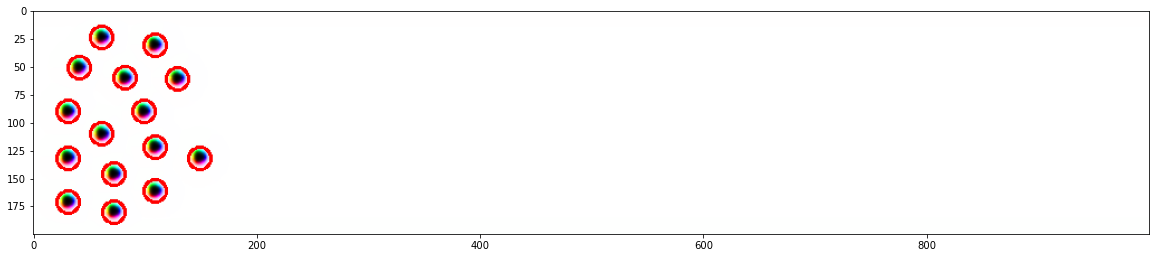

Getting frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 125.92it/s]


In [4]:
# show which frames we will be working on
print('**Particles used for training**')
show_tracked(data, directory)

# format data so that it is in the format (frame, next_frame)
frames = get_frames(data)

# data in columns ['frame', 'next_frame']
df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(frames)):
    df = df.append({'frame': frames[i-1], 'next_frame': frames[i]}, ignore_index=True)

In [5]:
### Batch definition to create training examples ###

def get_batch(frames, seq_length, batch_size):
    # the length of the vectorized songs string
    n = frames.shape[0] - 1
    # randomly choose the starting indices for the examples in the training batch
    idx = np.random.choice(n-seq_length, batch_size)

    input_batch = [frames[i : i+seq_length] for i in idx]
    output_batch = [frames[i+1 : i+seq_length+1] for i in idx]

    # x_batch, y_batch provide the true inputs and targets for network training
    x_batch = np.reshape(input_batch, [batch_size, seq_length, 2*no_skyrmions])
    y_batch = np.reshape(output_batch, [batch_size, seq_length, 2*no_skyrmions])
    return x_batch, y_batch

In [6]:
x_batch, y_batch = get_batch(np.array(frames), seq_length=10, batch_size=1)

# print(x_batch)
# print(y_batch)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {}".format(input_idx))
    print("  expected output: {}".format(target_idx))

Step   0
  input: [ 988.76572859   71.70355838  979.59200181   47.77306409  913.60048632
   61.94       1031.46568694   83.50792891 1073.43343613   22.42161398
  902.45374449  167.47828823  946.69677629  121.00188864  940.54532976
   49.71546222 1036.1883984   138.81381305  891.44545339  135.59740919
 1017.33982434   47.74829539  980.48094765  129.95747736  981.49222374
  152.69457026  795.28096823  185.24683812  954.64528919  175.32745925]
  expected output: [1009.28584513   79.46466568  991.08693556   48.57705287  920.56644518
   60.85331504 1042.16885389   85.43657043 1087.70133747   19.8900752
  915.7926141   166.07479042  954.80228939  123.45645408  955.42334031
   49.14330183 1048.50339469  135.28571429  903.41605649  132.17429393
 1029.45883492   43.38709008 1008.07379291  131.40736813  990.22186534
  156.58717653  808.53854109  183.11256066  964.20179372  177.77310864]
Step   1
  input: [1009.28584513   79.46466568  991.08693556   48.57705287  920.56644518
   60.85331504 1042.1

In [7]:
x_batch.shape

(1, 10, 30)

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

### Defining the RNN Model ###
def build_model(rnn_units, batch_size):
    model = Sequential()

    model.add(SimpleRNN(rnn_units, batch_input_shape=x_batch.shape, return_sequences=True))
    model.add(Dense(2 * no_skyrmions))

    return model

model = build_model(rnn_units=1024, batch_size=32)
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (1, 10, 1024)             1080320   
_________________________________________________________________
dense_1 (Dense)              (1, 10, 30)               30750     
Total params: 1,111,070
Trainable params: 1,111,070
Non-trainable params: 0
_________________________________________________________________


In [13]:
x, y = get_batch(np.array(frames), seq_length=100, batch_size=32)
x = tf.convert_to_tensor(x, np.float32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100, 30)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 30) # (batch_size, sequence_length, vocab_size)


In [17]:
example_batch_loss = tf.keras.losses.MeanSquaredError(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

ValueError: Invalid Reduction Key [[[ 944.77835699   75.58522799  946.77914843 ...  185.76633853
    903.80335792  175.51678962]
  [ 955.59790354   72.58022746  952.99754396 ...  186.15709202
    912.66905124  179.60547259]
  [ 971.61960531   68.39728243  957.35912463 ...  185.46691112
    924.43040701  177.56699346]
  ...
  [2066.53767943  111.43293959 1992.42907441 ...  164.25418974
   1918.82439175  149.68838928]
  [2071.49500197  114.88295946 2005.67070218 ...  172.45782045
   1930.45351722  148.58223876]
  [2084.44318663  113.314854   2007.52090058 ...  169.5384933
   1946.69898887  150.25074562]]

 [[6667.31306641  160.52150683 6586.6622776  ...  152.16737869
   6368.45375125  128.41459116]
  [6677.13788024  160.50799146 6594.37173358 ...  154.6098637
   6376.59376755  129.544825  ]
  [6691.8897473   154.50507001 6608.78472179 ...  149.19513458
   6391.56101073  129.57656036]
  ...
  [7720.43838992  130.74555038 7681.60632881 ...  126.81280788
   7411.07841878  101.69841177]
  [7732.54829216  135.72585392 7693.44190327 ...  129.57291902
   7417.54360143  100.80363297]
  [7748.22912264  139.8226873  7700.63718324 ...  124.22673603
   7432.6525883   101.92661808]]

 [[4371.98111826   96.19020103 4255.18557225 ...  166.75724764
   4141.45426983  166.51454559]
  [4385.05545482   98.57464491 4265.48013292 ...  168.15134745
   4152.79038263  164.54155114]
  [4400.88308249   96.13791099 4285.44093423 ...  169.73196527
   4158.28471002  166.78090217]
  ...
  [5488.37623642  139.74239942 5332.67036194 ...  165.71908084
   5228.46772352  171.27225096]
  [5500.59520651  135.27098258 5341.00334775 ...  170.58778168
   5233.07455895  173.45190389]
  [5510.08036163  138.94056588 5347.05076958 ...  167.40779679
   5247.76369207  174.41874122]]

 ...

 [[5392.20244316  120.27906345 5230.37773483 ...  161.21338138
   5133.32157688  168.13854285]
  [5401.17535948  124.6996732  5246.64927362 ...  161.43400317
   5143.46628811  170.99886432]
  [5416.59238496  123.26185471 5257.46907981 ...  162.79773771
   5154.38565055  174.56329993]
  ...
  [6438.41775177  172.6938355  6359.51764463 ...  158.17585211
   6131.50520833  127.68805556]
  [6457.61955588  172.30848976 6372.60274054 ...  165.74267473
   6145.65126896  123.24852987]
  [6465.81507225  173.56606304 6389.65952545 ...  162.49839134
   6160.90381655  126.13815736]]

 [[2870.89113866  117.3222614  2796.55599408 ...  145.81033684
   2715.80574628  178.52989801]
  [2877.52000254  120.52458182 2799.06384774 ...  143.06216607
   2725.55564941  179.54941199]
  [2886.34351884  119.43664017 2813.63996125 ...  141.71777818
   2735.23343827  182.47820916]
  ...
  [3959.79927654   88.38690687 3833.36343175 ...  148.1763349
   3754.47286213  171.42434555]
  [3969.41995256   91.99066113 3848.50261704 ...  149.80779604
   3765.70171849  170.39934534]
  [3980.69572463   89.48484072 3855.3103072  ...  148.54238032
   3773.19941558  171.40831169]]

 [[1191.757736     79.17851547 1157.71648087 ...  171.77615941
   1128.15367568  180.67542582]
  [1200.27440855   82.81361835 1170.50241185 ...  171.68290265
   1141.24575207  181.42743802]
  [1210.13594146   82.7505629  1181.24311811 ...  167.45759705
   1154.42603022  177.01555791]
  ...
  [2294.74082569  114.22225511 2200.52834342 ...  160.12286335
   2150.43678388  165.75398393]
  [2302.53278563  116.598664   2208.25499917 ...  167.91772695
   2159.2070632   166.88252788]
  [2311.22636198  117.81834741 2221.69059977 ...  168.04779998
   2176.93916501  166.09542744]]].